<a href="https://colab.research.google.com/github/MattHodgman/ProteoHist/blob/main/cohort_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore cohort statistics
- confounders
- batch effects
- etc.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn3, venn3_circles

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/BIOINF_590/Data/Metadata/metadata.csv')

## Continuous Variables
I believe the column 'Age_at_Diagnosis' has been shifted for deidentification.

In [ ]:
continuous_cols = ['Weight','Tumor_Percent_Tumor_Nuclei','Tumor_Percent_Total_Cellularity',
                   'Tumor_Percent_Necrosis','BMI','Age', 'Group']

In [ ]:
def get_stats(df0, stat):
  
  df0 = df0[continuous_cols]

  if stat == 'mean':
    df0 = df0.groupby('Group').mean().T
  elif stat == 'std':
    df0 = df0.groupby('Group').std().T

  df0.columns.name = None
  df0.index.name = None

  return df0

In [ ]:
get_stats(df, 'mean')

,both,normal,tumor
Weight,94.829444,92.152381,96.444444
Tumor_Percent_Tumor_Nuclei,79.444444,NaN,91.660000
Tumor_Percent_Total_Cellularity,92.361111,NaN,91.860000
Tumor_Percent_Necrosis,2.111111,NaN,2.200000
BMI,33.624167,36.472692,35.417800
Age,64.583333,65.923077,62.440000


In [ ]:
get_stats(df, 'std')

,both,normal,tumor
Weight,28.732809,21.950425,30.040475
Tumor_Percent_Tumor_Nuclei,12.117153,NaN,2.479384
Tumor_Percent_Total_Cellularity,5.054858,NaN,7.289943
Tumor_Percent_Necrosis,2.944998,NaN,2.770103
BMI,9.972221,8.614412,10.491055
Age,9.946643,8.084173,10.069473


In [ ]:
df_cont_m = get_stats(df, 'mean')
df_cont_std = get_stats(df, 'std')

df_cont_m['both'] = df_cont_m['both'].round(1).astype(str) + ' (±' + df_cont_std['both'].round(1).astype(str) + ')'
df_cont_m['normal'] = df_cont_m['normal'].round(1).astype(str) + ' (±' + df_cont_std['normal'].round(1).astype(str) + ')'
df_cont_m['tumor'] = df_cont_m['tumor'].round(1).astype(str) + ' (±' + df_cont_std['tumor'].round(1).astype(str) + ')'

In [ ]:
df_cont_m.to_csv('/content/drive/MyDrive/BIOINF_590/Data/group_continuous_variables_mean_std.csv')

## Categorical Variables

In [ ]:
categorical_cols = ['Specimen_Type','Tumor_Site_histology','Tumor_Histological_Type',
                    'Tumor_Segment_Acceptable','Progression_or_Recurrence',
                    'Ethnicity_histology','Race_histology',
                    'Vital_Status','Proteomics_TMT_batch','Country',
                    'Histologic_Grade_FIGO','Myometrial_invasion_Specify','Histologic_type',
                    'tumor_Stage-Pathological','Diabetes',
                    'Tumor_Site_proteomics','Tumor_Site_Other']

In [ ]:
def myfunc(df0):
  dfs = []

  for col in categorical_cols:

    df = pd.DataFrame(df0.groupby('Group')[col].value_counts())
    df = df.rename(columns={col : 'value'})
    df['Group'] = df.index.get_level_values(0)
    df = df.droplevel(0)
    df = df.pivot(columns='Group', values='value')
    df = pd.concat({col: df}, names=['Feature'])
    dfs.append(df)

  # combine features dfs
  df = pd.DataFrame()
  for feature_df in dfs:
    df = pd.concat([df,feature_df])

  df = df.fillna(0)

  # add percentage columns
  n_normal = df0['Group'].value_counts()['normal']
  n_tumor = df0['Group'].value_counts()['tumor']
  n_both = df0['Group'].value_counts()['both']
  
  df['normal'] = df['normal'].astype(int).astype(str) + ' (' + ((df['normal'] / n_normal) * 100).round(1).astype(str) + '%)'
  df['tumor'] = df['tumor'].astype(int).astype(str) + ' (' + ((df['tumor'] / n_tumor) * 100).round(1).astype(str) + '%)'
  df['both'] = df['both'].astype(int).astype(str) + ' (' + ((df['both'] / n_both) * 100).round(1).astype(str) + '%)'

  # df['normal_freq'] = ((df['normal'] / n_normal)).round(2)
  # df['tumor_freq'] = ((df['tumor'] / n_tumor)).round(2)
  # df['both_freq'] = ((df['both'] / n_both)).round(2)

  df.columns.name = None
  df.index.names = (None,None)

  return df

In [ ]:
df_categorical_variables = myfunc(df)

In [ ]:
df_categorical_variables

In [ ]:
df_categorical_variables.to_csv('/content/drive/MyDrive/BIOINF_590/Data/group_categorical_variables_formatted.csv')

## Other

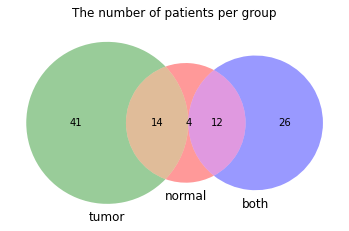

In [ ]:
# Stratify patients by what groups their samples are in

normal_patients = set(df[df['Group'] == 'normal']['Case_ID'].unique())
tumor_patients = set(df[df['Group'] == 'tumor']['Case_ID'].unique())
both_patients = set(df[df['Group'] == 'both']['Case_ID'].unique())

venn3([normal_patients, tumor_patients, both_patients], ('normal', 'tumor', 'both'))

plt.title('The number of patients per group')
plt.show()

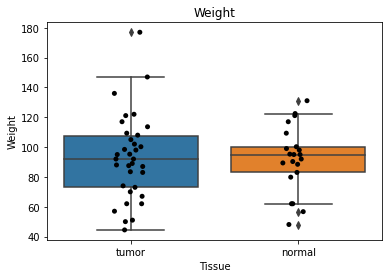

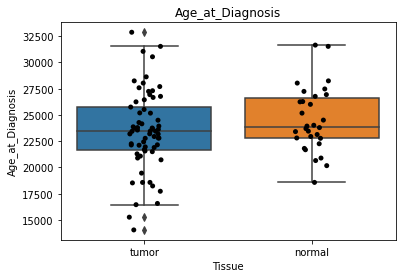

In [ ]:
# Plot numerical variables in DF1
for col in ['Weight','Age_at_Diagnosis']:
  df = df1[[col, 'Tissue']]
  sns.stripplot(data=df, x='Tissue', y=col, color='black')
  sns.boxplot(data=df, x='Tissue', y=col)
  plt.title(col)
  plt.show()